# Analyzing Multi-viewpoint Observations with the SunPy Ecosystem
## *Hinode* 14/IRIS 11 Joint Science Meeting - 29 October 2021
### Will Barnes (NRC Postdoc at NRL)
### *with many thanks to: Micah Weberg, Harry Warren, Albert Shih, David Stansby, Stuart Mumford, The SunPy Community*

This tutorial will demonstrate how the `sunpy` core package, along with several affiliated packages as well as the `eispac` software, can be used to analyze an active region as observed by multiple observatories from drastically different viewpoints.

This tutorial will emphasize the three core areas of functionality that `sunpy` provides:

* Data search and download
* Data containers for commonly used data products
* Coordinate transformations and reprojections between solar coordinate systems

Additionally, this tutorial will emphasize how other packages can both utilize and augment the capabilities provided by the `sunpy` core package. In particular, we emphasize the use of level 3 EIS observations in conjunction with other observatories, especially the Extreme Ultraviolet Imager (EUI) on *Solar Orbiter*.

Below are a few helpful links for finding out more about SunPy, including our webpage, documentation, and our Matrix channel:

* [sunpy.org](https://sunpy.org/)
* [SunPy Documentation](https://docs.sunpy.org/en/stable/)
* [Tutorial Notebooks from 2021 AAS/SPD SunPy Workshop](https://github.com/sunpy/aas-2021-workshop)
* [List of Affiliated Packages](https://sunpy.org/project/affiliated.html)
* [Matrix Chat](https://openastronomy.element.io/#/room/#sunpy:openastronomy.org)
* [OpenAstronomy Discourse](https://community.openastronomy.org/c/sunpy/5)

![sunpy](images/sunpy-summary-slide.png)
![affiliated packages](images/affiliated-package-slide.png)

In [1]:
import copy
import glob

from astropy.coordinates import SkyCoord
import astropy.time
import astropy.units as u
import astropy.wcs
from astropy.visualization import ImageNormalize, quantity_support
import eispac  # This registers the EISMap class
import matplotlib.pyplot as plt
import numpy as np
import pfsspy
from reproject import reproject_interp
import sunpy.coordinates
import sunpy.image.coalignment
import sunpy.map
from sunpy.net import Fido,attrs as a
import sunpy_soar  # This registers the SOAR Fido client
from sunpy_soar.attrs import Identifier

In [2]:
print('astropy version:', astropy.__version__)
print('sunpy version: ', sunpy.__version__)
print('pfsspy version: ', pfsspy.__version__)

astropy version: 4.3.1
sunpy version:  3.1.0rc1
pfsspy version:  0.6.6


We will load in an EIS observation of the Fe XII 195.119 Å intensity. This data is inlcuded in the `data/` directory, but the `fit-eis-data.py` script shows how to produce these files. Also see Micah's tutorial on the `eispac` software from this morning.

In [3]:
m_eis = sunpy.map.Map('data/eis_fe_xii_195.119_intensity.fits')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


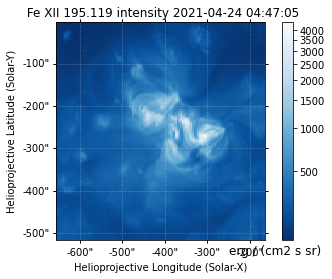

In [4]:
m_eis.peek()

Note the `type` of this map instance. The `EISMap` class is automatically registered with sunpy when we import `eispac`. `eispac` is able to provide support for EIS data through the `sunpy` "map factory" without modifying the underlying `sunpy` source code.

In [5]:
type(m_eis)

eispac.core.eismap.EISMap

## Data Search and Download

First, we will search for SDO/AIA and SDO/HMI, STEREO A/SECCHI, and *Solar Orbiter* EUI observations around the time of the EIS raster that we loaded above.

Use of the `near=...` keyword here tells the datasource to return only the observation closests to that date that falls between the dates specified by `start=...` and `end=...`. We will construct four queries in total, one for each instrument, but they will all share a common time search attribute. Note that this capability easily allows to find concurrent observations from multiple observatories.

In [6]:
time_range = a.Time(m_eis.date_start-10*u.minute,
                    end=m_eis.date_end,
                    near=m_eis.date_average)

We can use the `date_start`, `date_end`, and `date_average` properties on our EIS map to construct this query. As of `sunpy` v3.1, these three different times are now exposed as properties to distinguish between the start, end, and middle of the observing period, respectively, as opposed to the singluar `.date` property. 

We've made a small adjustment of $-10$ minutes to the start of the search interval because the closest STEREO image is just outside of the interval defined by the start time of the EIS raster. You can verify this by removing this adjustment and noting that the subsequent query does not return any results for STEREO

In [7]:
euv_171 = time_range & a.Wavelength(171*u.angstrom) & a.Physobs.intensity
aia_query = euv_171 & a.Instrument.aia
euvi_query = euv_171 & a.Instrument.secchi

In [8]:
hmi_query = time_range & a.Instrument.hmi & a.Physobs.los_magnetic_field

Note here that the interface to the ESA SOAR archive containing the EUI data is provided by the `sunpy_soar` package, external to the core `sunpy` pacakge. Similar to the `EISMap`, we "register" the SOAR client with `Fido` simply by importing `sunpy_soar`.

In [9]:
eui_query = time_range & a.Level(2) & a.Instrument('EUI') & Identifier('EUI-FSI174-IMAGE')

We can now pass all four of these queries to `Fido.search`. Joining them by an **OR** operator `|` tells `Fido.search` that we want four separate results.

In [10]:
q = Fido.search(aia_query | euvi_query | hmi_query | eui_query)

In [11]:
q

<sunpy.net.fido_factory.UnifiedResponse object at 0x13a4d8b50>
Results from 4 Providers:

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search

       Start Time               End Time        Source ... Extent Type   Size                              Info                          
                                                       ...              Mibyte                                                           
----------------------- ----------------------- ------ ... ----------- -------- ---------------------------------------------------------
2021-04-24 04:47:09.000 2021-04-24 04:47:10.000    SDO ...    FULLDISK 64.64844 AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search

       Start Time               End Time         Source  Instrument ... Wavetype Extent Type   Size              Info            
                                                                    ...                       Mibyte                             
----------------------- ----------------------- -------- ---------- ... -------- ----------- ------- ----------------------------
2021-04-24 04:09:30.000 2021-04-24 04:09:38.000 STEREO_A     SECCHI ...   NARROW    FULLDISK 8.02002 EUVI ;  ; NORMAL ; 2048x2048

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search

       Start Time               End Time        Source Instrument ... Extent Length Extent Type   Size          Info       
                                                                  ...                            Mibyte                    
----------------------- ----------------------- ------ ---------- ... ------------- ----------- -------- ------------------
2021-04-24 04:47:03.000 2021-04-24 04:47:04.000    SDO        HMI ...          4096    FULLDISK -0.00098 45sec. Magnetogram

1 Results from the SOARClient:
Instrument   Data product   Level        Start time               End time        Filesize
---------- ---------------- ----- ----------------------- ----------------------- --------
       EUI EUI-FSI174-IMAGE    L2 2021-04-24 04:46:43.347 2021-04-25 04:46:43.347  35.6 MB

As expected, we get four results back, three from the VSO (for AIA, STEREO, and HMI) and one from the SOAR archive (for EUI).

We can now pass our resulting query to `Fido.fetch` to download the data. By default, this will be downloaded to `~/sunpy/data`, but we can redirect it using the `path=...` keyword.

In [20]:
files = Fido.fetch(q, path='data/')

In [21]:
files = sorted(files)

In [12]:
# Use this block in the event that the download is hanging.
files = sorted(glob.glob('data/*.f*ts'))
files.pop(2)  # We just want the imaging data at the moment

'data/eis_fe_xii_195.119_intensity.fits'

In [13]:
files

['data/20210424_040930_n4eua.fts',
 'data/aia_lev1_171a_2021_04_24t04_47_09_35z_image_lev1.fits',
 'data/hmi_m_45s_2021_04_24_04_48_00_tai_magnetogram.fits',
 'data/solo_L2_eui-fsi174-image_20210424T044643347_V01.fits']

## Reading Image Data into `Map`

Next, we take the resulting files and create `Map` objects from each of them.

In [14]:
m_euvi, m_aia, m_hmi, m_eui = sunpy.map.Map(files)

We can then easily visualize each of these maps using the `plot` command

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


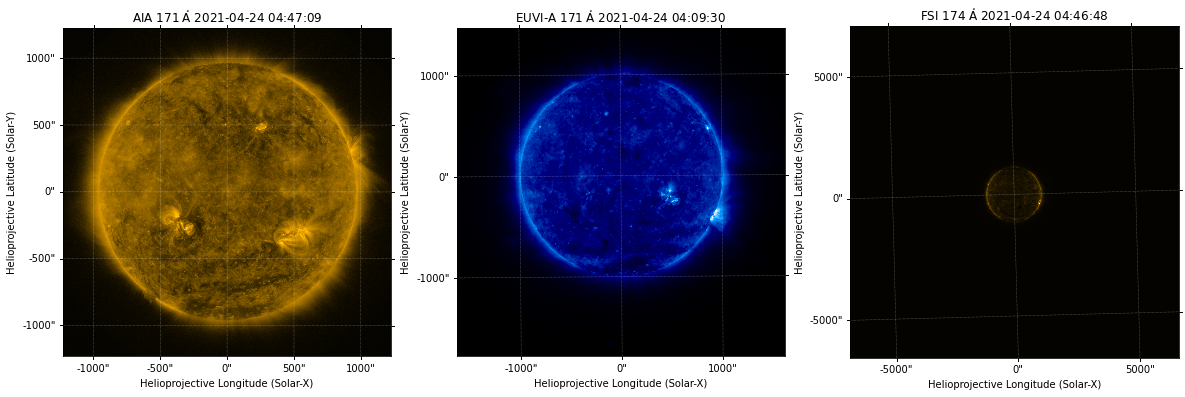

In [15]:
fig = plt.figure(figsize=(20,7.5))
for i,m in enumerate([m_aia, m_euvi, m_eui]):
    ax = fig.add_subplot(1,3,i+1,projection=m)
    m.plot(axes=ax)

### Useful Properties on Map

Recall that `Map` provides a common interface to any 2D imaging data and provides several useful pieces of metadata, including the date properties we used above to construct our magnetogram and EUV image queries.

The `.meta` and `.data` attributes provide access to the metadata and underlying array of image data, respectively.

In [16]:
m_aia.data

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 1,  0,  1, ..., -1, -2,  0],
       [ 0,  1,  0, ...,  0,  1,  2],
       ...,
       [ 0, -1,  0, ...,  1,  2, -2],
       [ 0, -1, -1, ...,  2,  0,  1],
       [ 0, -1,  0, ..., -2, -2,  0]], dtype=int16)

In [17]:
m_aia.meta

MetaDict([('simple', True),
          ('bitpix', 16),
          ('naxis', 2),
          ('naxis1', 4096),
          ('naxis2', 4096),
          ('pcount', 0),
          ('gcount', 1),
          ('xtension', 'BINTABLE'),
          ('bld_vers', 'V9R41X'),
          ('lvl_num', 1.0),
          ('t_rec', '2021-04-24T04:47:10Z'),
          ('trecstep', 1.0),
          ('trecepoc', '1977.01.01_00:00:00_TAI'),
          ('trecroun', 1),
          ('origin', 'SDO/JSOC-SDP'),
          ('date', '2021-04-28T03:34:39'),
          ('telescop', 'SDO/AIA'),
          ('instrume', 'AIA_3'),
          ('date-obs', '2021-04-24T04:47:09.35'),
          ('t_obs', '2021-04-24T04:47:10.35Z'),
          ('camera', 3),
          ('img_type', 'LIGHT'),
          ('exptime', 2.000159),
          ('expsdev', 0.000132),
          ('int_time', 2.273438),
          ('wavelnth', 171),
          ('waveunit', 'angstrom'),
          ('wave_str', '171_THIN'),
          ('fsn', 233732386),
          ('fid', 0),
        

This includes things like wavelength

In [18]:
print(m_eis.wavelength)
print(m_aia.wavelength)
print(m_euvi.wavelength)
print(m_eui.wavelength)

195.119 Angstrom
171.0 Angstrom
171.0 Angstrom
174.0 Angstrom


or processing level

In [19]:
print(m_eis.processing_level)
print(m_aia.processing_level)
print(m_euvi.processing_level)
print(m_eui.processing_level)

3
1.0
None
2


### Units

Let's look at the units of the image data in each map.

In [20]:
print(m_eis.unit)
print(m_aia.unit)
print(m_euvi.unit)
print(m_eui.unit)

erg / (cm2 s sr)
ct
ct
ct / s


Note that while the EUI data has been normalized to the exposure time, the AIA and STEREO images have not been normalized. We can do this simply by dividing these maps by their exposure time. The ability to do arithmetic with `Map` objects directly like this is a new feature in `sunpy` v3.1.

In [21]:
m_aia = m_aia / m_aia.exposure_time
m_euvi = m_euvi / m_euvi.exposure_time

Note that these arithmetic operations properly handle units via the `astropy.units` subpackage.

In [22]:
print(m_aia.unit)
print(m_euvi.unit)

ct / s
ct / s


We'll leave the EIS data in physical units.

### Coordinate Systems

There is a lot of useful information about which coordinate system corresponds to each observation. Note that while all three are in a Helioprojective (HPC) coordinate frame, each of one of these frames is dramatically different due to the relative separation of the three spacecraft.

In [23]:
print(m_aia.coordinate_frame)
print(m_euvi.coordinate_frame)
print(m_eui.coordinate_frame)

<Helioprojective Frame (obstime=2021-04-24T04:47:09.350, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-04-24T04:47:09.350, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01125567, -4.82067958, 1.50479242e+11)>)>
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
<Helioprojective Frame (obstime=2021-04-24T04:09:30.007, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-04-24T04:09:30.007, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-53.29366636, -7.32617213, 1.44564197e+11)>)>
<Helioprojective Frame (obstime=2021-04-24T04:46:48.347, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-04-24T04:46:48.347, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-97.75052812, 0.1521256, 1.30404241e+11)>)>


In [24]:
print(m_eis.observer_coordinate.lon.to('deg'))
print(m_aia.observer_coordinate.lon.to('deg'))
print(m_euvi.observer_coordinate.lon.to('deg'))
print(m_eui.observer_coordinate.lon.to('deg'))

0d00m00s
-0d00m40.52042015s
-53d17m37.19888448s
-97d45m01.90124871s


The advantage of having observations of a single active region from multiple observatories is that we can see the resulting structures from multiple viewpoints. We can use the metadata from each map to visualize the relative locations of the three observatories. The locations of SDO and *Hinode* lie directly on top of one another, as expected. 

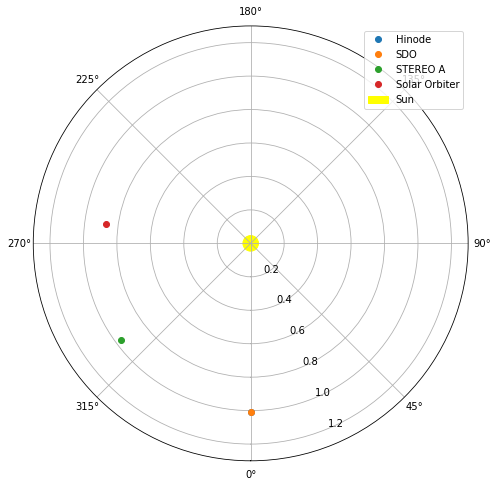

In [25]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')
# Plot the Sun
circle = plt.Circle((0.0, 0.0), (10*u.Rsun).to_value(u.AU),
                    transform=ax.transProjectionAffine + ax.transAxes,
                    color="yellow",
                    alpha=1,
                    label="Sun")
ax.add_patch(circle)
# Plot the satellite locations
for m in [m_eis, m_aia, m_euvi, m_eui]:
    sat = m.observatory
    coord = m.observer_coordinate
    ax.plot(coord.lon.to('rad'), coord.radius.to(u.AU), 'o', label=sat)
ax.set_theta_zero_location("S")
ax.set_rlim(0, 1.3)
ax.legend()

### Fixing the EIS Pointing with AIA

It is possible that the EIS pointing in these level 3 FITS files may be off, sometimes by an amount of order 10" in longitude.
We can account for this by adjusting the EIS pointing using a cross-correlation with the AIA.
We'll using the functionality provided by [scikit-image](https://scikit-image.org/) as implemented in the `sunpy.image.coalignment` subpackage to do this.

First, resample the AIA map to the same resolution as the EIS map

In [26]:
n_x = (m_aia.scale.axis1 * m_aia.dimensions.x) / m_eis.scale.axis1
n_y = (m_aia.scale.axis2 * m_aia.dimensions.y) / m_eis.scale.axis2
m_aia_r = m_aia.resample(u.Quantity([n_x, n_y]))

Next, compute the shifts, in pixels, needed to align the resampled AIA and EIS maps by cross-correlating the two images.

In [27]:
yshift, xshift = sunpy.image.coalignment.calculate_shift(m_aia_r.data, m_eis.data)

Then find the corresponding coordinate at this pixel position in the resampled AIA map.
This can be interpreted as the location of the bottom left pixel of the EIS raster in the pixel coordinates of the AIA image. 

In [28]:
reference_coord = m_aia_r.pixel_to_world(xshift, yshift)

To find the amount we need to shift the original EIS map by, we can take the difference between these two coordinates and then use the `shift` method on `Map` to apply this correction to the reference coordinate (i.e. the `CRVAL` keys).

In [29]:
Txshift = reference_coord.Tx - m_eis.bottom_left_coord.Tx
Tyshift = reference_coord.Ty - m_eis.bottom_left_coord.Ty
print(Txshift)
print(Tyshift)
m_eis_fixed = m_eis.shift(Txshift, Tyshift)

7.3411arcsec
-0.550904arcsec


We can see the difference by overplotting the AIA 171 intensity

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(-0.5, 122.5, -0.5, 511.5)

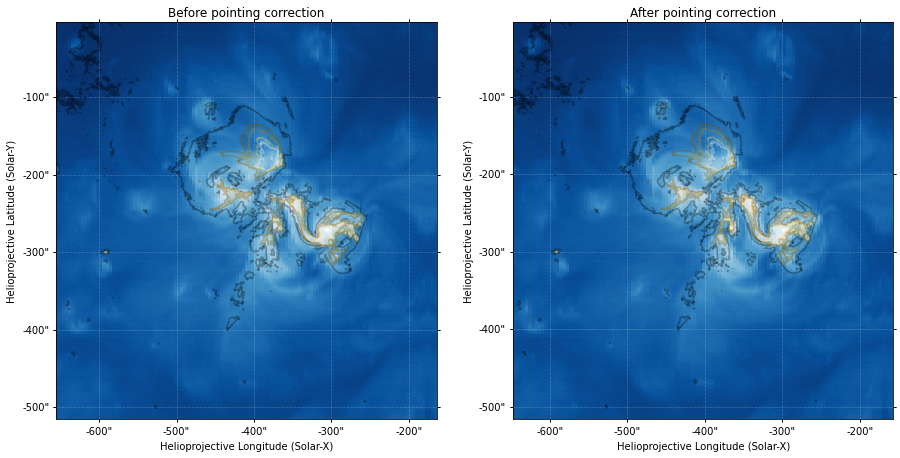

In [30]:
levels = [200, 400, 500, 700, 800] * m_aia.unit
fig = plt.figure(figsize=(15,7.5))
ax = fig.add_subplot(121, projection=m_eis)
m_eis.plot(axes=ax, title='Before pointing correction')
bounds = ax.axis()
m_aia.draw_contours(levels, axes=ax, cmap='sdoaia171', alpha=0.3)
ax.axis(bounds)
ax = fig.add_subplot(122, projection=m_eis_fixed)
m_eis_fixed.plot(axes=ax, title='After pointing correction')
bounds = ax.axis()
m_aia.draw_contours(levels, axes=ax, cmap='sdoaia171', alpha=0.3)
ax.axis(bounds)

We can verify this fix again by comparing the corrected and uncorrected center coordinates and noting that the difference is the same as our calculated shifts above, as expected.

In [31]:
print(m_eis_fixed.center.Tx - m_eis.center.Tx)
print(m_eis_fixed.center.Ty - m_eis.center.Ty)

7.3411arcsec
-0.550903arcsec


### Cropping to a Common Field of View

Now, let's crop all of the maps to the (adjusted) EIS FOV in order to see the different views of the active region offered by the different observatories.

We construct the cropped maps by calculating the width and height of the EIS raster, transforming the center coordinate of the EIS raster to the coordinate frame of each observation, and then calculating the bottom left coordinate from this transformed coordinate

In [32]:
eis_fov_width = m_eis_fixed.dimensions.x * m_eis_fixed.scale.axis1
eis_fov_height = m_eis_fixed.dimensions.y * m_eis_fixed.scale.axis2

In [33]:
cropped_maps = []
for m in [m_aia, m_eui, m_euvi]:
    center = m_eis_fixed.center.transform_to(m.coordinate_frame)
    blc = SkyCoord(center.Tx-eis_fov_width/2, center.Ty-eis_fov_height/2, frame=center.frame)
    cropped_maps.append(m.submap(blc, width=eis_fov_width, height=eis_fov_height))
m_aia_cropped, m_eui_cropped, m_euvi_cropped = cropped_maps

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


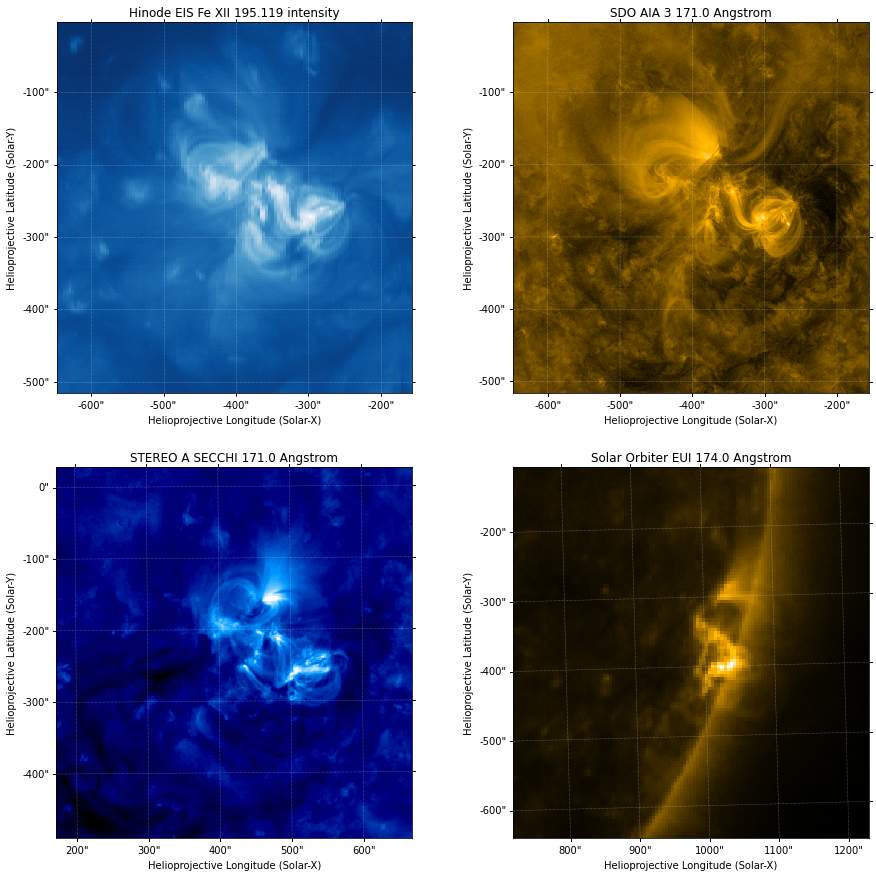

In [34]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate([m_eis_fixed, m_aia_cropped, m_euvi_cropped, m_eui_cropped]):
    ax = fig.add_subplot(2,2,i+1,projection=m)
    m.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')

Note that we could have used the `.bottom_left_coord` and `.top_right_coord` attributes of `m_eis` to do the cropping as well.
However, this would have showed less offlimb emission in the EUI observation.

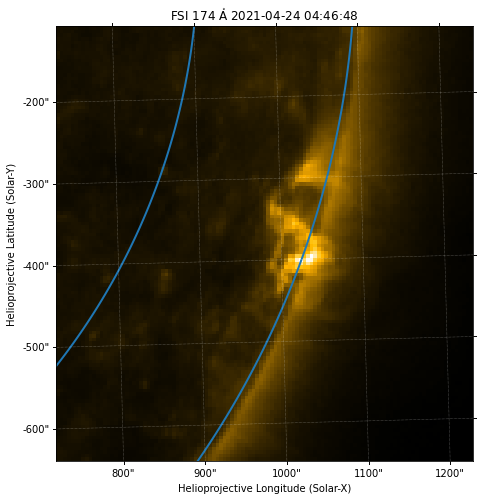

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=m_eui_cropped)
m_eui_cropped.plot(axes=ax)
m_eui_cropped.draw_quadrangle(m_eis_fixed.bottom_left_coord,
                              top_right=m_eis_fixed.top_right_coord,
                              lw=2,
                              edgecolor='C0')

## Reprojection and Field Extrapolation

In order to showcase the coordinate transformation capabilities of `sunpy` combined with these multi-viewpoint observations, we want to do construct a model of the 3D magnetic field for this active region.
We can do this using the corresponding HMI LOS magnetic field observation and the [`pfsspy`](https://pfsspy.readthedocs.io/en/stable/) package.

`pfsspy` computes the field extrapolation from a synoptic magnetogram so we will first need to reproject our HMI LOS magnetogram into a synoptic map using the `reproject` package.

In [36]:
shape_out=[540, 1080]
frame_out = SkyCoord(0, 0, unit=u.deg, rsun=m_hmi.coordinate_frame.rsun, frame="heliographic_stonyhurst", obstime=m_hmi.date)
header = sunpy.map.make_fitswcs_header(
    shape_out,
    frame_out,
    scale=[180 / shape_out[0], 360 / shape_out[1]] * u.deg / u.pix,
    projection_code="CAR",
)
out_wcs = astropy.wcs.WCS(header)
array, _ = reproject_interp(m_hmi, out_wcs, shape_out=shape_out)
array = np.where(np.isnan(array), 0, array)
m_hmi_cea = pfsspy.utils.car_to_cea(sunpy.map.Map(array, header))
m_hmi_cea.meta['TELESCOP'] = m_hmi.meta['TELESCOP']
m_hmi_cea.meta['CONTENT'] = 'Carrington Synoptic Chart Of Br Field'
m_hmi_cea.meta['T_OBS'] = m_hmi_cea.meta.pop('DATE-OBS')  # This is because of a bug where the date accidentally returns None if it is in the date-obs key
m_hmi_cea = sunpy.map.Map(
    m_hmi_cea.data,
    m_hmi_cea.meta,
    plot_settings={'norm': ImageNormalize(vmin=-1.5e3,vmax=1.5e3), 'cmap': 'hmimag'}
)

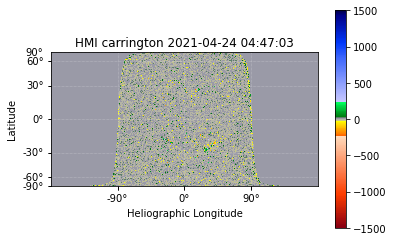

In [37]:
m_hmi_cea.peek()

In [38]:
nrho = 70
rss = 2.5
pfss_input = pfsspy.Input(m_hmi_cea, nrho, rss)
output = pfsspy.pfss(pfss_input)
m_hmi_cea.plot_settings = {'norm': ImageNormalize(vmin=-1.5e3,vmax=1.5e3), 'cmap': 'hmimag'}

/Users/wbarnes/miniconda3/envs/sunpy-hinode-iris-2021/lib/python3.9/site-packages/pfsspy/pfss.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 1d, F), array(complex128, 1d, A))
  cdlm = np.dot(Q[:, l], brt[:, m]) / lam[l]


**Word of Caution:** We are performing the field extrapolation on a synoptic map created by reprojecting a LOS magnetogram. While this is likely to provide a decent estimate of the local, AR-scale field structure, this method will not adequately capture the global structure of the coronal magnetic field. To compute a more accurate representation of the global coronal field, one should use a true synoptic magnetogram instead.

## Field Extrapolation and Fieldline Coordinates

We'll choose seedpoints to do our fieldline tracing based on the photospheric field strength. We'll place a seedpoint in every pixel where the field strength is below 30 G.
We'll then convert these pixel positions to coordinates using the `pixel_to_world` method on the magnetogram.

In [39]:
masked_pix_y, masked_pix_x = np.where(m_hmi_cea.data < -3e1)
seeds = m_hmi_cea.pixel_to_world(masked_pix_x*u.pix, masked_pix_y*u.pix,).make_3d()

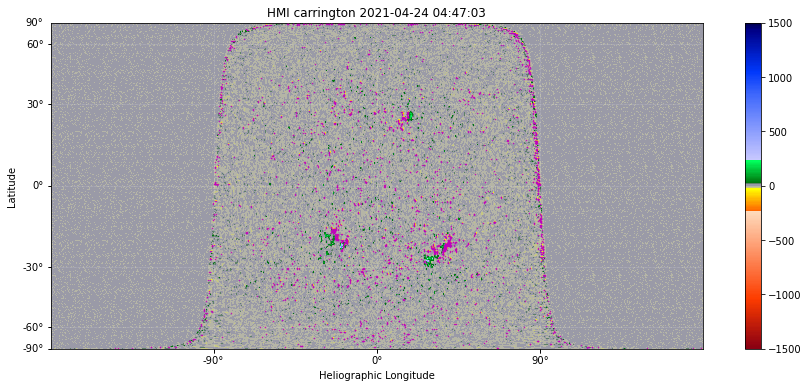

In [40]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111,projection=m_hmi_cea)
m_hmi_cea.plot(axes=ax,)
ax.plot_coord(seeds, marker='.', color='m', markersize=1, ls='')
plt.colorbar()

Furthermore, we want to find only those seed points that fall inside the EIS FOV.
We can use the bottom left and top right coordinates of our EIS map to select only those points.

In [41]:
seeds_hpc = seeds.transform_to(m_eis_fixed.coordinate_frame)
in_lon = np.logical_and(seeds_hpc.Tx > m_eis_fixed.bottom_left_coord.Tx,
                        seeds_hpc.Tx < m_eis_fixed.top_right_coord.Tx)
in_lat = np.logical_and(seeds_hpc.Ty > m_eis_fixed.bottom_left_coord.Ty,
                        seeds_hpc.Ty < m_eis_fixed.top_right_coord.Ty)
seeds_eis = seeds[np.where(np.logical_and(in_lon, in_lat))]

If we plot our selected seed points along with the EIS FOV projected onto the magnetogram, we can see that we've properly selected only those seed points within the EIS FOV.

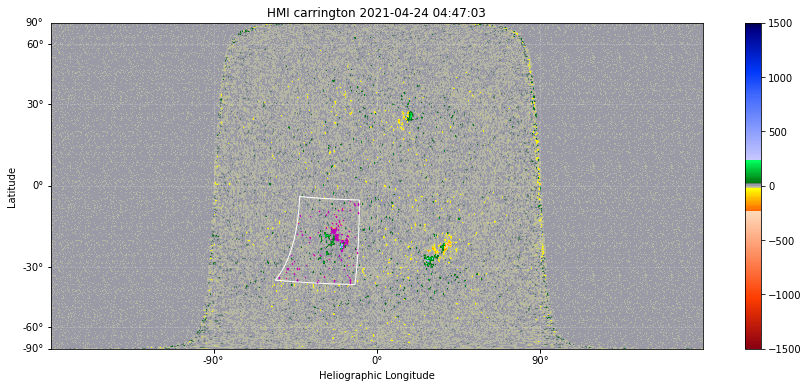

In [42]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111,projection=m_hmi_cea)
m_hmi_cea.plot(axes=ax,)
ax.plot_coord(seeds_eis, marker='.', color='m', markersize=1, ls='')
m_hmi_cea.draw_quadrangle(m_eis_fixed.bottom_left_coord, top_right=m_eis_fixed.top_right_coord)
plt.colorbar()

Finally, we can trace fieldlines from these seedpoints

In [43]:
tracer = pfsspy.tracing.FortranTracer()

In [44]:
fieldlines = tracer.trace(SkyCoord(seeds_eis), output,)

## Projecting Fieldlines Onto Images

Finally, we'll take these 3D fieldine coordinates, reproject them into the different coordinate systems of each map, and overlay them on top of each of our maps to explore how the 3D structure of the extrapolated coronal field looks from the three different viewpoints.

We'll first define a simple function that calculates the length of each fieldline so that we can exclude very short fieldlines.

In [45]:
def get_loop_length(line):
    c = line.coords.cartesian.xyz
    s = np.append(0., np.linalg.norm(np.diff(c.value, axis=1), axis=0).cumsum()) * c.unit
    return np.diff(s).sum()

We project each fieldline onto the image using the `plot_coord` function. Note that the coordinate conversion to the projected frame is done automatically.

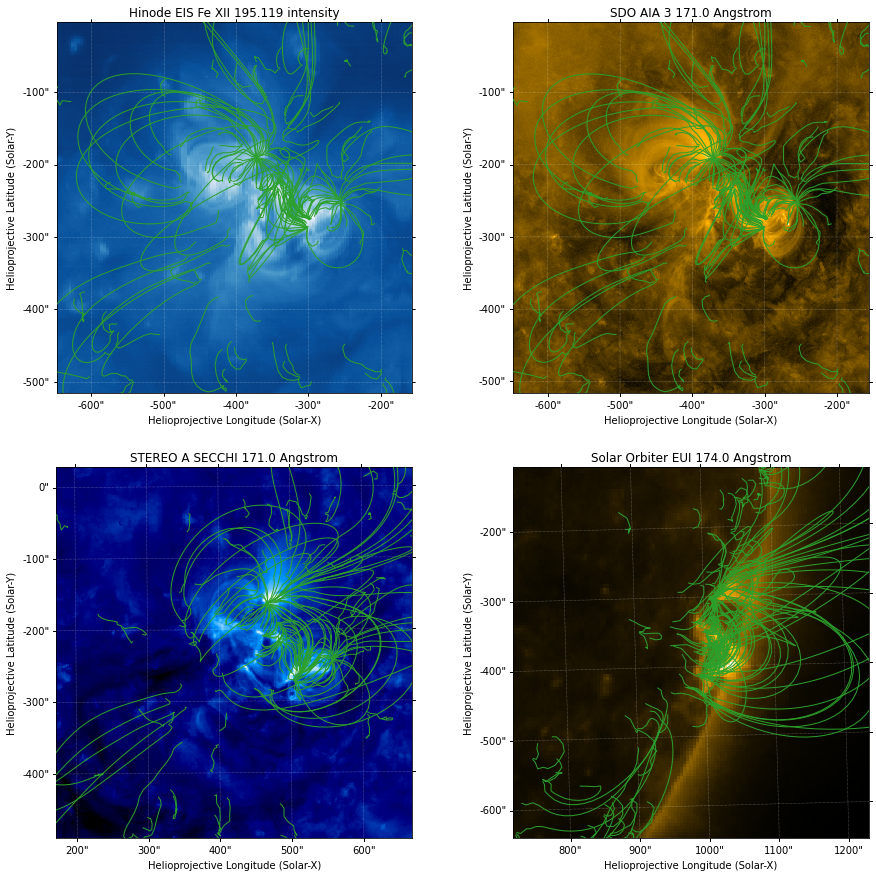

In [46]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate([m_eis_fixed, m_aia_cropped, m_euvi_cropped, m_eui_cropped]):
    ax = fig.add_subplot(2,2,i+1,projection=m)
    m.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')
    bounds = ax.axis()
    for f in fieldlines:
        if get_loop_length(f) > 20 * u.Mm:
            ax.plot_coord(f.coords, ls='-', lw=1, color='C2', alpha=1)
    ax.axis(bounds)

## Extracting Intensity Data Along Fieldlines

Lastly, we want to use one of these coordinates to extract the intensity at each pixel along the coordinate for each of our maps.
Select a loop near that roughly traces an intensity enhancement near the core of our active region as observed by EIS and AIA.

In [47]:
loop_coord = fieldlines[181].coords

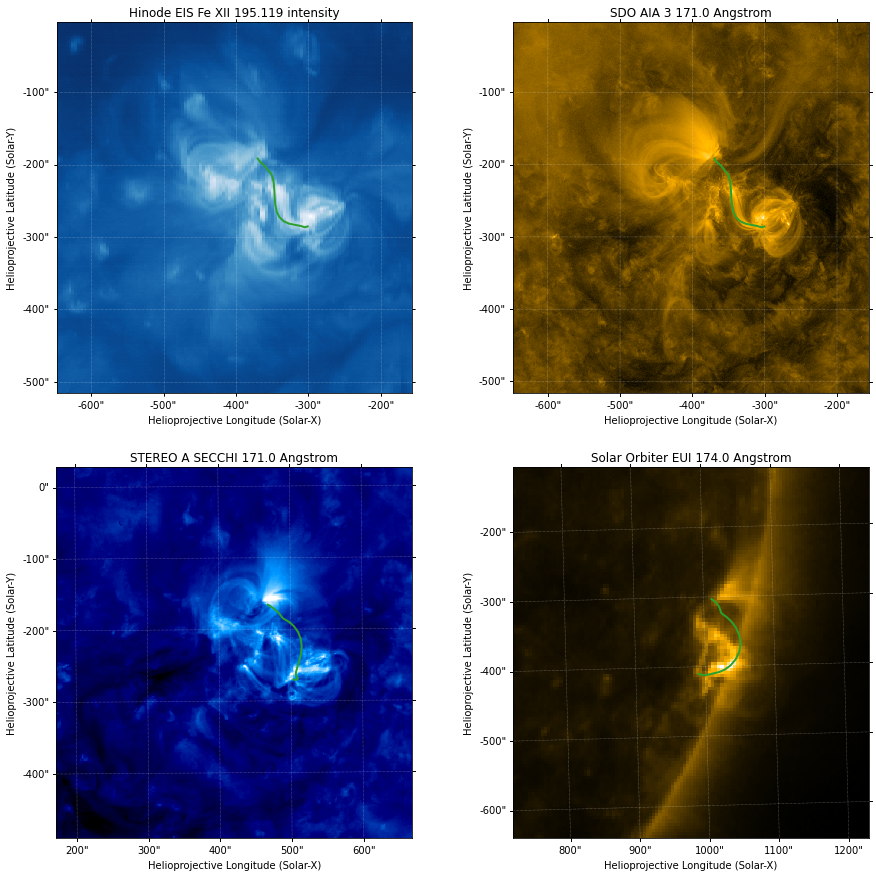

In [48]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate([m_eis_fixed, m_aia_cropped, m_euvi_cropped, m_eui_cropped]):
    ax = fig.add_subplot(2,2,i+1,projection=m)
    m.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')
    bounds = ax.axis()
    ax.plot_coord(loop_coord, ls='-', lw=2, color='C2', alpha=1)
    ax.axis(bounds)

We'll define a few functions that help to identify pixels corresponding to coordinates.
The first is an implementation of [Bresenham's line algorithm](https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm) which finds the path in integer pixel space that intersects our coordinate.
The second function just applies this algorithim to each segment between each point in our selected coordinate.

In [49]:
def bresenham(x1, y1, x2, y2):
    """
    Returns an array of all pixel coordinates which the line defined by `x1, y1` and
    `x2, y2` crosses. Uses Bresenham's line algorithm to enumerate the pixels along
    a line. This was adapted from ginga

    Parameters
    ----------
    x1, y1, x2, y2 :`int`

    References
    ----------
    | https://github.com/ejeschke/ginga/blob/master/ginga/BaseImage.py#L387
    | http://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    | https://ginga.readthedocs.org/en/latest/
    """
    for x in [x1, y1, x2, y2]:
        if type(x) not in (int, np.int64):
            raise TypeError('All pixel coordinates must be of type int')
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy
    res = []
    x, y = x1, y1
    while True:
        res.append((x, y))
        if (x == x2) and (y == y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err = err - dy
            x += sx
        if e2 <  dx:
            err = err + dx
            y += sy
    return np.array(res)


def get_intersecting_pixels(coord, image_wcs):
    # Find pixels between each loop segment
    px, py = image_wcs.world_to_pixel(coord)
    px = np.round(px).astype(int)
    py = np.round(py).astype(int)
    loop_pix = []
    for i in range(px.shape[0]-1):
        b = bresenham(px[i], py[i], px[i+1], py[i+1])
        # Pop the last one, unless this is the final entry because the first point
        # of the next section will be the same
        if i < px.shape[0]-2:
            b = b[:-1]
        loop_pix.append(b)
    return np.vstack(loop_pix)

Now, let's overlay our original coordinate and our "Bresenham coordinate" on top of our map to verify we are still tracing out our feature of interest.

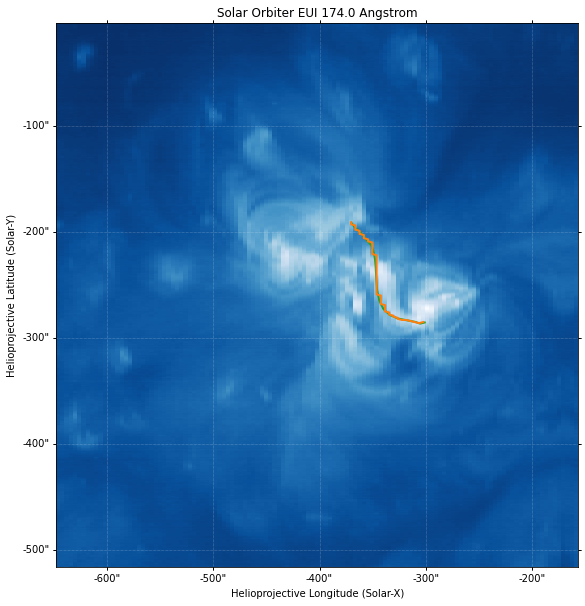

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=m_eis_fixed)
m_eis_fixed.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')
ax.plot_coord(loop_coord, ls='-', lw=2, color='C2', alpha=1)
pix = get_intersecting_pixels(loop_coord, m_eis_fixed.wcs)
ax.plot(pix[:,0], pix[:,1], ls='-', lw=2, color='C1', alpha=1)

Finally, we can calculate our Bresenham coordinate for each map to get the corresponding array indices and use these to extract the intensity.
We then plot each intensity profile as a function of distance along the loop for each map.

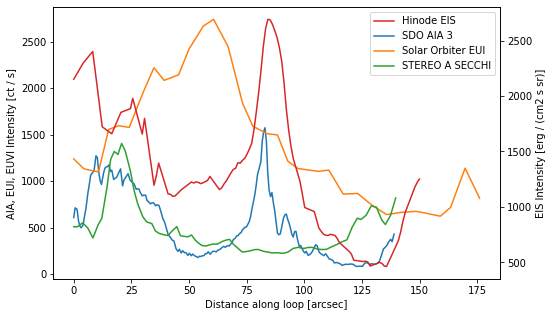

In [51]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
lines = []
for m in [m_eis_fixed, m_aia_cropped, m_eui_cropped, m_euvi_cropped]:
    pix = get_intersecting_pixels(loop_coord, m.wcs)
    intensity = m.data[pix[:,1], pix[:,0]] * m.unit
    c = m.pixel_to_world(pix[:,0]*u.pix, pix[:,1]*u.pix)
    c_data = u.Quantity([c.Tx, c.Ty]).to('arcsec').value
    loop_s = np.append(0., np.linalg.norm(np.diff(c_data, axis=1), axis=0).cumsum()) #* u.arcsec
    if m.instrument == 'EIS':
        lines += ax2.plot(loop_s, intensity,label=f'{m.observatory} {m.instrument}',color='C3')
    else:
        lines += ax.plot(loop_s, intensity,label=f'{m.observatory} {m.instrument}')
ax.set_xlabel('Distance along loop [arcsec]')
ax.set_ylabel(f'AIA, EUI, EUVI Intensity [{m_aia.unit}]')
ax2.set_ylabel(f'EIS Intensity [{m_eis.unit}]')
ax.legend(lines, [l.get_label() for l in lines],)